In [162]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [ ]:
import os
from PIL import Image
i = 0 
for file in os.listdir("./"):
    if file.endswith(".npy"):
        print(file)
        img_array = np.load('./'+ file)
        # creating a rgb channel from grayscale image as PIL doesnt save it in this format       
        rgb_batch = np.repeat(img_array[..., np.newaxis], 3, -1)
        # scaling to 255 again due to contraints of PIL
        im = Image.fromarray((rgb_batch * 255).astype(np.uint8))
        pngfilename = file.replace('.npy', '.png')
        print(pngfilename)
        im.save(pngfilename)

## Approach One - Traditional Computer vision 

We will be calculating the convex hull area and perimeter as well as surface area and perimeter using the opencv library to see if it has any correlation with stickiness.

<img style="float: right;" src="area.JPG">


<img style="float: right;" src="perimeter.JPG">


<img style="float: right;" src="compactness.JPG">


### I had thought of using compactness as well but  then thought of using neural nets to let them create features of their own. I also calculated the radius of minimum circle that can fit the contour.

<img style="float: right;" src="contours.png">


### In the above picture all the contours are considered.

<img style="float: right;" src="contours_single.png">


### In the above picture only the outermost contour selected

%pwd

In [ ]:
import pandas as pd

In [ ]:
dataset = pd.read_csv("contours.csv",encoding="utf-8")

In [ ]:
dataset.head()

The first approach that I have taken is to use contour functianality in opencv to calculate several key things abt the fractal geometry 

In [ ]:
import os
import cv2
import cv2 as cv

for file in os.listdir("./"):  # going through all  the files
    if file.endswith(".png"):   # selecting those with .png
#         print(file)
        dictionary = {}         # empty directory to fill values
        new = file.rstrip(".png")   # removes .png from file name 
#         print(new)
        x = new.split("particles")   # creates a list like with [stickesss10, 1000]  the second element is number of particles
#         print(x)
        y = x[0].split('stickness')  # creates a list like ["",10]   the econd element is the stickiness
        
        particles = int(x[1])           # converting to int
        
        k = int(y[1])*0.001

        img1 = cv2.imread("../Locus/"+file)
        img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        # # Threshold the image
        ret, thresh = cv2.threshold(img,100,255,0)
        # Find the contours
        contour, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)   # calculates the contours from the image
        # For each contour, find the convex hull and draw it
        
        
        hull = cv2.convexHull(contour[0])  # creates a convex hull from the top most contour. 
        area_hull = cv.contourArea(hull)  # area of convex hull of the top most contour 
        perimeter_hull = cv.arcLength(hull,True)   # perimeter of convex hull of the topmost contour
        
        area_contour = cv.contourArea(contour[0])   # area of the top most contour 
        perimeter_contour = cv.arcLength(contour[0],True)   # perimeter of the top most contour
        Total_area_contour = 0
        Total_perimeter_contour = 0
        
        for i in range(len(contour)):
                Total_area_contour += cv.contourArea(contour[i])       # adding up all areas of contour 
                Total_perimeter_contour = cv.arcLength(contour[i],True)


        (x, y), radius = cv2.minEnclosingCircle(contour[0])  # gives the circle that can bind the contour
        
        dictionary['particles']= particles
        dictionary['stickness']= k
        dictionary['perimeter_hull'] = perimeter_hull

        dictionary['area_hull'] = area_hull
        dictionary['area_total'] = area_contour
        
        dictionary['perimeter_total']= perimeter_contour
        
        dictionary['radius_circle'] = radius   
        
        dictionary['Total_area_contour'] = Total_area_contour
        
        dictionary["Total_perimeter_contour"] = Total_perimeter_contour

             
        dataset = dataset.append(dictionary, ignore_index=True)

        
        
        #         print(file)

In [ ]:
dataset.head()

In [ ]:
new_dataset = dataset.drop(columns=['index'])


In [117]:
grouped_particles_70k = new_dataset[new_dataset['particles'] == 70000]    #Trying to group by particle number and visualizing the graphs

# new_dataset['area_normalized']= new_dataset.radius_circle/(new_dataset.particles)

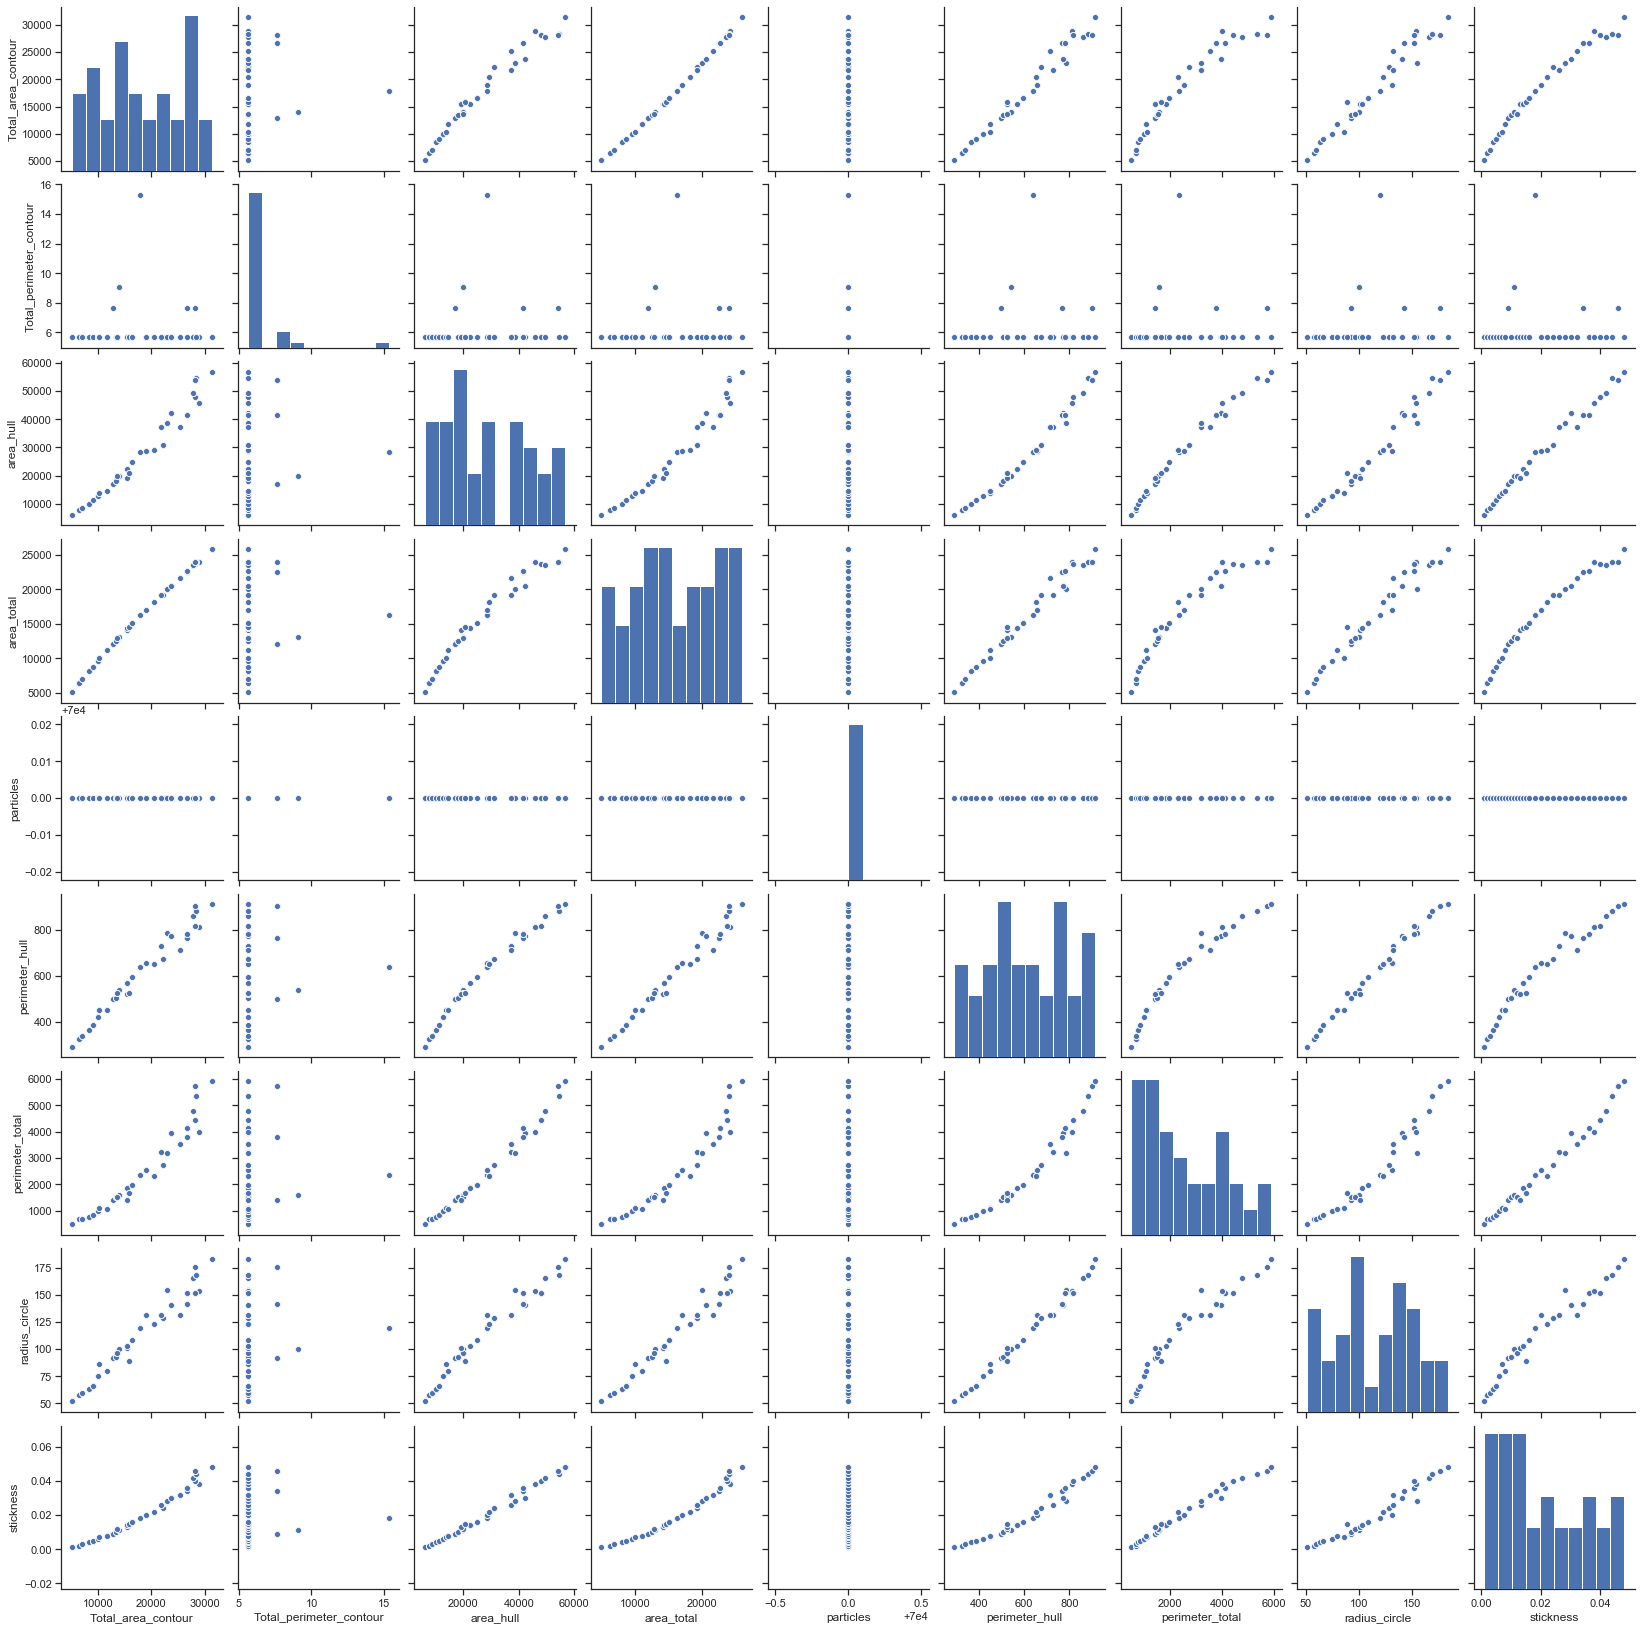

In [119]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
# iris = sns.load_dataset("iris")
g = sns.pairplot(grouped_particles_80k)

We can see that area_hull, area_total, perimeter_total, perimeter_hull and radius_circle are all correlated to stickines. However, a lot of these features are correlated to each other so cannot use all of them in analysis 

In [ ]:
new_dataset.to_csv('final_dataset.csv')

In [132]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures

data = pd.read_csv("final_dataset.csv")

In [121]:
data.head()

,Total_area_contour,Total_perimeter_contour,area_hull,area_total,particles,perimeter_hull,perimeter_total,radius_circle,stickness
0,192.5,5.656854,263.5,188.5,1000,62.391058,91.982755,11.520029,0.001
1,1990.5,5.656854,2478.5,1867.0,10000,186.283941,336.274166,34.792339,0.010
2,2164.5,5.656854,2808.0,2036.0,11000,198.953713,354.073156,36.667522,0.010
3,2303.0,5.656854,3037.0,2193.5,12000,206.740323,398.600067,37.831963,0.010
4,2489.5,5.656854,3254.0,2348.0,13000,214.265984,426.357426,38.785736,0.010


data.shape

In [125]:
X = data[['area_hull']].copy()


In [126]:
X['area_hull']= X.area_hull/data.particles # dividing by the number of particles. Without this the accuracy was low

In [ ]:
# X = data[['area_hull']].copy()


In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [130]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [131]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Root Mean Squared Error: 0.003550797068846513


### The rsme for test is 0.003. Not that good but does give you a ballpark figure of the stickiness.

In [135]:
polynomial_features= PolynomialFeatures(degree=2)
polynomial_features.fit(X_train)

x_poly_train = polynomial_features.transform(X_train)
x_poly_test = polynomial_features.transform(X_test)

model = LinearRegression()
model.fit(x_poly_train, y_train)
y_pred = model.predict(x_poly_test)

### fitting a polynomial to linear regression. Again rmse is not affected

In [136]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Root Mean Squared Error: 0.003470400818459126


## Trying to fit a neural net to see if it works

from keras import models,layers

In [103]:
model =  Sequential()

In [110]:
model.add(layers.Dense(8,activation='relu',input_shape = [X_train.shape[1]]))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(16,activation='relu'))

model.add(layers.Dense(1))

In [111]:
model.compile(optimizer='rmsprop', loss = 'mse' , metrics= ['mae'])

In [112]:
history = model.fit(X_train_scaled,y_train,validation_split = 0.2, epochs = 100)

Train on 4915 samples, validate on 1229 samples
Epoch 1/100
4915/4915 [==============================] - 0s 95us/step - loss: 4.9107e-05 - mae: 0.0051 - val_loss: 2.6020e-05 - val_mae: 0.0034
Epoch 2/100
4915/4915 [==============================] - 0s 31us/step - loss: 3.9143e-05 - mae: 0.0045 - val_loss: 2.5253e-05 - val_mae: 0.0036
Epoch 3/100
4915/4915 [==============================] - 0s 29us/step - loss: 3.5622e-05 - mae: 0.0043 - val_loss: 3.5676e-05 - val_mae: 0.0046
Epoch 4/100
4915/4915 [==============================] - 0s 35us/step - loss: 3.4203e-05 - mae: 0.0042 - val_loss: 3.9875e-05 - val_mae: 0.0049
Epoch 5/100
4915/4915 [==============================] - 0s 32us/step - loss: 3.3475e-05 - mae: 0.0041 - val_loss: 3.2901e-05 - val_mae: 0.0038
Epoch 6/100
4915/4915 [==============================] - 0s 31us/step - loss: 3.1767e-05 - mae: 0.0040 - val_loss: 1.9979e-05 - val_mae: 0.0031
Epoch 7/100
4915/4915 [==============================] - 0s 31us/step - loss: 3.1534e-05

Epoch 57/100
4915/4915 [==============================] - 0s 33us/step - loss: 1.5585e-05 - mae: 0.0028 - val_loss: 1.3824e-05 - val_mae: 0.0026
Epoch 58/100
4915/4915 [==============================] - 0s 29us/step - loss: 1.5150e-05 - mae: 0.0027 - val_loss: 1.2490e-05 - val_mae: 0.0024
Epoch 59/100
4915/4915 [==============================] - 0s 31us/step - loss: 1.5241e-05 - mae: 0.0027 - val_loss: 2.9096e-05 - val_mae: 0.0039
Epoch 60/100
4915/4915 [==============================] - 0s 32us/step - loss: 1.5048e-05 - mae: 0.0027 - val_loss: 2.3636e-05 - val_mae: 0.0037
Epoch 61/100
4915/4915 [==============================] - 0s 31us/step - loss: 1.4929e-05 - mae: 0.0027 - val_loss: 1.3958e-05 - val_mae: 0.0025
Epoch 62/100
4915/4915 [==============================] - 0s 32us/step - loss: 1.5322e-05 - mae: 0.0027 - val_loss: 1.7418e-05 - val_mae: 0.0029
Epoch 63/100
4915/4915 [==============================] - 0s 31us/step - loss: 1.4746e-05 - mae: 0.0027 - val_loss: 1.2682e-05 - v

In [113]:
 h , k = model.evaluate(X_test_scaled,y_test)

1536/1536 [==============================] - 0s 17us/step


In [114]:
test_rmse =  h**0.5

In [115]:
test_rmse

0.005326871980702088

### Worse off then Linear regression. Again i should have removed the correlated features but even then it was improving.

# Other Approches in mind 

- I wanted to fine tune a resnet on the dataset to regress the stickiness. However,didnt show it because the results were not impressive. The reason which comes to mind is since it is near impossible for a human to predict stickiness seeing the image it may be wrong to ask for the CNN to detect features to regress.
- Use scikit learn to extract features - Using kernels like Prewitt Kernel, Sobel Kernel and canny kernel and use them to regress

